# 【課題】量子計算

```{contents} 目次
---
local: true
---
```

$\newcommand{\ket}[1]{|#1\rangle}$

## 問題1: 足し算を実機で行う

実習の内容の延長です。ここでは並列足し算回路を実機で実行します。

実習のおさらいをすると、まずもともとの足し算のロジックをそのまま踏襲した回路を作り、それではゲート数が多すぎるので効率化した回路を作成しました。

実は効率化した回路でもまだゲートの数が多すぎて、4ビット+4ビットの計算では答えがスクランブルされてしまいます。回路が小規模になればそれだけ成功確率も上がりますので、$(n_1, n_2)$の値として(4, 4)以外に(3, 3)、(2, 2)、(1, 1)も同時に試すことにしましょう。

In [1]:
# まずは全てインポート
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, QuantumCircuit, IBMQ, Aer, transpile
from qiskit.providers.ibmq import least_busy, IBMQAccountCredentialsNotFound
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qc_workbook.optimized_additions import optimized_additions
from qc_workbook.utils import operational_backend, find_best_chain

print('notebook ready')

notebook ready


実習と同様、`'ibm-q/open/main'`のプロバイダでは(1, 1)の回路しか扱えないので、フェイクバックエンドを使います。

In [2]:
provider_def = ('ibm-q', 'open', 'main')

try:
    IBMQ.load_account()
except IBMQAccountCredentialsNotFound:
    IBMQ.enable_account('__paste_your_token_here__')

provider = IBMQ.get_provider(*provider_def)

RequestsApiError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

In [3]:
if provider_def == ('ibm-q', 'open', 'main'):
    from qiskit.test.mock import FakeGuadalupe
    
    backend = FakeGuadalupe()

else:
    backend_list = provider.backends(filters=operational_backend(min_qubits=13))
    backend = least_busy(backend_list)

print(f'Using backend {backend.name()}')

Using backend fake_guadalupe


実習を参考に、次のセルで効率化前の回路を返す`make_original_circuit`関数を実装してください。

In [4]:
def make_original_circuit(n1, n2):
    """A function to define a circuit with the original implementation of additions given n1 and n2
    """
    n3 = np.ceil(np.log2((2 ** n1) + (2 ** n2) - 1)).astype(int)

    reg1 = QuantumRegister(n1, 'r1')
    reg2 = QuantumRegister(n2, 'r2')
    reg3 = QuantumRegister(n3, 'r3')

    # QuantumCircuit can be instantiated from multiple registers
    circuit = QuantumCircuit(reg1, reg2, reg3)
    
    ##################
    ### EDIT BELOW ###
    ##################

    #circuit.?

    ##################
    ### EDIT ABOVE ###
    ##################
    
    circuit.measure_all()

    return circuit

(4, 4)から(1, 1)までそれぞれオリジナルと効率化した回路の二通りを作り、全てリストにまとめてバックエンドに送ります。

In [5]:
# count_ops()の結果をテキストにする関数
def display_nops(circuit):
    nops = circuit.count_ops()
    text = []
    for key in ['rz', 'x', 'sx', 'cx']:
        text.append(f'N({key})={nops.get(key, 0)}')
        
    return ', '.join(text)

# オリジナルと効率化した回路を作る関数
def make_circuits(n1, n2, backend):
    print(f'Original circuit with n1, n2 = {n1}, {n2}')
    circuit_orig = make_original_circuit(n1, n2)
    
    print('  Transpiling..')
    circuit_orig = transpile(circuit_orig, backend=backend, optimization_level=3)
    
    print(f'  Done. Ops: {display_nops(circuit_orig)}')
    circuit_orig.name = f'original_{n1}_{n2}'

    print(f'Optimized circuit with n1, n2 = {n1}, {n2}')
    circuit_opt = optimized_additions(n1, n2)
    
    n3 = np.ceil(np.log2((2 ** n1) + (2 ** n2) - 1)).astype(int)

    print('  Transpiling..')
    initial_layout = find_best_chain(backend, n1 + n2 + n3)
    circuit_opt = transpile(circuit_opt, backend=backend, routing_method='basic',
                            initial_layout=initial_layout, optimization_level=3)

    print(f'  Done. Ops: {display_nops(circuit_opt)}')
    circuit_opt.name = f'optimized_{n1}_{n2}'

    return [circuit_orig, circuit_opt]

In [6]:
# テキスト作成用のセル

import os
if os.getenv('JUPYTERBOOK_BUILD') == '1':
    shots = backend.configuration().max_shots
    del backend

In [7]:
# List of circuits
circuits = []
for n1, n2 in [(4, 4), (3, 3), (2, 2), (1, 1)]:
    circuits += make_circuits(n1, n2, backend)

# バックエンドで定められた最大のショット数だけ各回路を実行
shots = backend.configuration().max_shots
    
print(f'Submitting {len(circuits)} circuits to {backend.name()}, {shots} shots each')

if backend.provider() is None:
    # Case: fake backend
    # フェイクバックエンドには何らかのバグがあり、一度に8つの回路を実行すると0000..という答えが多発する（2022-04-05 YI）
    counts_list = []
    for circuit in circuits:
        job = backend.run(circuit, shots=shots)
        counts_list.append(job.result().get_counts())
        
    print('Job Status: job has successfully run')
        
else:
    job = backend.run(circuits, shots=shots)

    job_monitor(job, interval=2)

    counts_list = job.result().get_counts()

NameError: name 'backend' is not defined

In [8]:
# テキスト作成用のセル

import pickle
if os.getenv('JUPYTERBOOK_BUILD') == '1':
    with open('data/quantum_computation_fake_data.pkl', 'rb') as source:
        counts_list = pickle.load(source)

ジョブが返ってきたら、正しい足し算を表しているものの割合を調べてみましょう。

In [9]:
def count_correct_additions(counts, n1, n2):
    """Extract the addition equation from the counts dict key and tally up the correct ones."""
    
    correct = 0

    for key, value in counts.items():
        # cf. plot_counts() from the SIMD lecture
        x1 = int(key[-n1:], 2)
        x2 = int(key[-n1 - n2:-n1], 2)
        x3 = int(key[:-n1 - n2], 2)

        if x1 + x2 == x3:
            correct += value

    return correct

    
icirc = 0
for n1, n2 in [(4, 4), (3, 3), (2, 2), (1, 1)]:
    for ctype in ['Original', 'Optimized']:
        n_correct = count_correct_additions(counts_list[icirc], n1, n2)
        r_correct = n_correct / shots
        print(f'{ctype} circuit ({n1}, {n2}): {n_correct} / {shots} = {r_correct:.3f} +- {np.sqrt(r_correct * (1. - r_correct) / shots):.3f}')
        icirc += 1

Original circuit (4, 4): 924 / 8192 = 0.113 +- 0.003
Optimized circuit (4, 4): 1953 / 8192 = 0.238 +- 0.005
Original circuit (3, 3): 2363 / 8192 = 0.288 +- 0.005
Optimized circuit (3, 3): 3269 / 8192 = 0.399 +- 0.005
Original circuit (2, 2): 4443 / 8192 = 0.542 +- 0.006
Optimized circuit (2, 2): 5262 / 8192 = 0.642 +- 0.005
Original circuit (1, 1): 6900 / 8192 = 0.842 +- 0.004
Optimized circuit (1, 1): 7074 / 8192 = 0.864 +- 0.004


ちなみに、`ibm_kawasaki`という実機で同じコードを走らせると、下のような結果が得られます。

<pre>
Original circuit with n1, n2 = 4, 4
  Transpiling..
  Done. Ops: N(rz)=170, N(x)=3, N(sx)=67, N(cx)=266
Optimized circuit with n1, n2 = 4, 4
  Transpiling..
  Done. Ops: N(rz)=175, N(x)=1, N(sx)=64, N(cx)=142
Original circuit with n1, n2 = 3, 3
  Transpiling..
  Done. Ops: N(rz)=120, N(x)=5, N(sx)=57, N(cx)=90
Optimized circuit with n1, n2 = 3, 3
  Transpiling..
  Done. Ops: N(rz)=117, N(x)=0, N(sx)=48, N(cx)=84
Original circuit with n1, n2 = 2, 2
  Transpiling..
  Done. Ops: N(rz)=50, N(x)=0, N(sx)=20, N(cx)=56
Optimized circuit with n1, n2 = 2, 2
  Transpiling..
  Done. Ops: N(rz)=67, N(x)=0, N(sx)=32, N(cx)=41
Original circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(rz)=25, N(x)=0, N(sx)=15, N(cx)=13
Optimized circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(rz)=27, N(x)=0, N(sx)=16, N(cx)=13
</pre>

<pre>
Original circuit (4, 4): 990 / 32000 = 0.031 +- 0.001
Optimized circuit (4, 4): 879 / 32000 = 0.027 +- 0.001
Original circuit (3, 3): 2435 / 32000 = 0.076 +- 0.001
Optimized circuit <b>(3, 3)</b>: 2853 / 32000 = <b>0.089 +- 0.002</b>
Original circuit (2, 2): 3243 / 32000 = 0.101 +- 0.002
Optimized circuit <b>(2, 2)</b>: 7994 / 32000 = <b>0.250 +- 0.002</b>
Original circuit <b>(1, 1)</b>: 25039 / 32000 = <b>0.782 +- 0.002</b>
Optimized circuit <b>(1, 1)</b>: 26071 / 32000 = <b>0.815 +- 0.002</b>
</pre>

回路が均一にランダムに$0$から$2^{n_1 + n_2 + n_3} - 1$までの数を返す場合、レジスタ1と2のそれぞれの値の組み合わせに対して正しいレジスタ3の値が一つあるので、正答率は$2^{n_1 + n_2} / 2^{n_1 + n_2 + n_3} = 2^{-n_3}$となります。実機では、(4, 4)と(3, 3)でどちらの回路も正答率がほとんどこの値に近くなっています。(2, 2)では効率化回路で明らかにランダムでない結果が出ています。(1, 1)では両回路とも正答率8割です。

フェイクバックエンドでは実機のエラーもシミュレートされていますが、エラーのモデリングが甘い部分もあり、$2^{-n_3}$よりは遥かに良い成績が得られています。いずれのケースも、回路が短い効率化バージョンの方が正答率が高くなっています。

### Quantum Volume

量子コンピュータがエラーを起こす頻度は、マシンによって違います。さらに言えば個々の量子ビットごとに1量子ビットゲートのエラー率と測定のエラー率[^measurement_error]があり、また量子ビット間の接続ごとにCNOTのエラー率があります。これまで使ってきた`find_best_chain()`という関数は、与えられたバックエンドの中でこれらのエラー率の積が最も小さくなるような量子ビットの並びを選んでくるものでした。

マシン自体のパフォーマンスを比較するには、`find_best_chain`でやるように各マシンの中から最も性能の良い量子ビットの組み合わせを選んできて、その上でベンチマークとなる回路を実行します。IBMQではそのようにして量子コンピュータ一つ一つをQuantum Volume（QV、量子体積）{cite}`PhysRevA.100.032328`という指標で評価しています。[^qv]。QVは簡単に言えば「量子コンピュータ上である特定の形を持った回路を安定的に実行できる量子ビット数と回路の長さ」を測っていて、QVの値が大きいマシンほど高性能と言えます。
QVにはゲートや測定のエラー率だけでなく、トランスパイラの性能なども関係します。2022年4月現在、IBMQのマシンでQVの最大値は128です。

`open`のプロバイダで使える5量子ビットマシンのうちでも、QVの値が異なるものがあるので、1ビット+1ビットの自明な例にはなってしまいますが、バックエンドを選んで足し算の正答率を比較してみましょう。

[^measurement_error]: 測定のエラーとは、具体的には状態$\ket{0}$や$\ket{1}$を測定したときにどのくらいの割合で0や1でない結果を得るかということを表した値です。
[^qv]: QVはハードウェアの詳細に依存しないように定義されているので、量子ビット型の量子コンピュータであればIBMのマシンに限らずすべてQVで評価できます。実際、業界で徐々にQVを標準ベンチマークとして使う動きが広がってきているようです。

In [10]:
backend_qv8 = least_busy(provider.backends(filters=operational_backend(qv=8)))
backend_qv16 = least_busy(provider.backends(filters=operational_backend(qv=16)))
backend_qv32 = least_busy(provider.backends(filters=operational_backend(qv=32)))

print(f'Using backends {backend_qv8.name()} (QV 8), {backend_qv16.name()} (QV 16), {backend_qv32.name()} (QV 32)')

NameError: name 'provider' is not defined

In [11]:
n1 = n2 = 1

jobs = []
for backend in [backend_qv8, backend_qv16, backend_qv32]:
    circuits = make_circuits(n1, n2, backend)
    shots = backend.configuration().max_shots
    job = backend.run(circuits)
    jobs.append(job)

for job, qv in zip(jobs, [8, 16, 32]):

    counts_list = job.result().get_counts()
    
    for counts, ctype in zip(counts_list, ['Original', 'Optimized']):
        n_correct = count_correct_additions(counts, n1, n2)
        r_correct = n_correct / shots
        print(f'QV {qv} {ctype} circuit ({n1}, {n2}): {n_correct} / {shots} = {r_correct:.3f} +- {np.sqrt(r_correct * (1. - r_correct) / shots):.3f}')

NameError: name 'backend_qv8' is not defined

QVから期待される正答率の序列にならないかもしれません。量子コンピュータという恐ろしく複雑な機械の性能を一つの数値で表すことの限界がここにあり、今のように単純な回路を実行する場合は、ケースバイケースで特定の量子ビットや特定のゲートのエラー率が結果に大きな影響を及ぼしたりするのです。

じっさい、`find_best_chain`関数が各バックエンドで算出したエラー率の積を比較すると、QVの大きいマシンが必ずしも低いエラー率を持っているわけではないことがわかります。

In [12]:
# find_best_chainで4量子ビットの列を探し、エラー率の積が最小になる組み合わせにおいてCNOTゲートエラー率の積と測定エラー率の積（の対数）をそれぞれ取得
_, log_gate_error_qv8, log_readout_error_qv8 = find_best_chain(backend_qv8, 4, return_error_prod=True)
_, log_gate_error_qv16, log_readout_error_qv16 = find_best_chain(backend_qv16, 4, return_error_prod=True)
_, log_gate_error_qv32, log_readout_error_qv32 = find_best_chain(backend_qv32, 4, return_error_prod=True)

print(f'QV 8 error rates: {log_gate_error_qv8:.2f} (CNOT), {log_readout_error_qv8} (readout)')
print(f'QV 16 error rates: {log_gate_error_qv16:.2f} (CNOT), {log_readout_error_qv16} (readout)')
print(f'QV 32 error rates: {log_gate_error_qv32:.2f} (CNOT), {log_readout_error_qv32} (readout)')

NameError: name 'backend_qv8' is not defined

**提出するもの**

- `make_original_circuit`関数のコード
- QV8, 16, 32の実機で各回路を実行した結果

## 問題2: 符号が反転している基底を見つける

実習の前半で出てきたequal superposition状態

$$
H^{\otimes n} \ket{0} = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \ket{k}
$$

をそのまま測定すると、全ての整数$k$に対応するビット列が等しい確率で現れます。測定でビット列が現れる確率はそのビット列に対応する計算基底の振幅の絶対値自乗で決まるので、重ね合わせにおいてある整数$\tilde{k}$の符号だけ逆転している以下の状態でもやはり全ての整数が確率$1/2^n$で得られます。

$$
\frac{1}{\sqrt{2^n}} \left( \sum_{k \neq \tilde{k}} \ket{k} - \ket{\tilde{k}} \right)
$$

（一般には、全ての計算基底にバラバラに位相因子$e^{i\theta_{k}}$がかかっていても確率は同じです。）

さて、{doc}`後の実習 <grover>`で登場するグローバー探索というアルゴリズムは、上のように一つの計算基底の符号を逆転させるブラックボックス演算子（どの基底かは事前に知られていない）が与えられたときに、符号の反転が起こっている計算基底を効率よく見つけ出すための手法です。グローバー探索を利用すると、例えば$N$個のエントリーのあるデータベースから特定のエントリーを探し出すのに、$\mathcal{O}(\sqrt{N})$回データベースを参照すればいいということがわかっています。

今から考えるのはそのような効率的な方法ではなく、同じようにブラックボックス演算子が与えられたときに、原理的には符号の反転が起こっている基底を見つけることができる、という手法です。そのために振幅の干渉を利用します。

まずは具体性のために$n=3$として、ブラックボックスは$k=5$の符号を反転させるとします。ここでブラックボックスの中身が完全に明かされてしまっていますが、これは実装上の都合で、重要なのは検索アルゴリズムが中身（5）を一切参照しないということです。

後で便利なように、まずはブラックボックスを単体の回路として定義します。

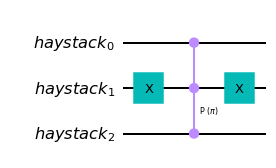

In [13]:
num_qubits = 3
needle = 5

haystack_register = QuantumRegister(num_qubits, name='haystack') # ビット数を指定してレジスタを作る
blackbox_circuit = QuantumCircuit(haystack_register, name='blackbox') # レジスタから回路を作る

# unpackbitsでneedleが二進数のビット列に変換される。それを1から引くことでビット反転
needle_bits = 1 - np.unpackbits(np.asarray(needle, dtype=np.uint8), bitorder='little')[:num_qubits]
for idx in np.nonzero(needle_bits)[0]:
    blackbox_circuit.x(haystack_register[idx])
    
# レジスタの（0番から）最後から二番目のビットまでで制御し、最後のビットを標的にする
blackbox_circuit.mcp(np.pi, haystack_register[:-1], haystack_register[-1])

# 後片付け
for idx in np.nonzero(needle_bits)[0]:
    blackbox_circuit.x(haystack_register[idx])
        
blackbox_circuit.draw('mpl')

ここまでは{doc}`circuit_from_scratch`の問題5と同じです。

Qiskitでは、QuantumCircuitオブジェクト全体を一つのゲートのようにみなして、それから制御ゲートを派生させることができます。

In [14]:
# blackbox_circuitを3量子ビットゲート化
blackbox = blackbox_circuit.to_gate()
# さらにblackboxゲートを1制御+3標的ビットゲート化
cblackbox = blackbox.control(1)

新たに定義した`cblackbox`ゲートは、$n+1$ビット回路に
```{code-block} python
circuit.append(cblackbox, qargs=range(circuit.num_qubits))
```
のようにして組み込むことができます。この場合、0番ビットが制御ビットになります。

それでは、この制御ブラックボックスゲートを利用して、equal superpositionにある`haystack`レジスタで干渉を起こして、観測で`needle`が識別できるような回路を書いてください。

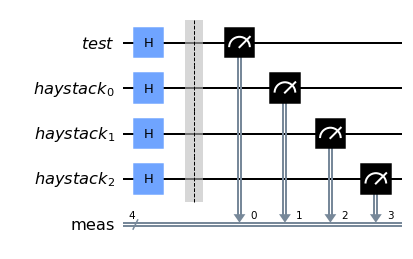

In [15]:
test_register = QuantumRegister(1, 'test')
test = test_register[0]
circuit = QuantumCircuit(test_register, haystack_register)

# equal superpositionを作る（このようにゲート操作のメソッドにレジスタを渡すと、レジスタの各ビットにゲートがかかります。）
circuit.h(haystack_register)

# 干渉を起こす方法のヒント
circuit.h(test)

##################
### EDIT BELOW ###
##################

#circuit.?

##################
### EDIT ABOVE ###
##################

circuit.measure_all()

circuit.draw('mpl')

回路が完成したら、`qasm_simulator`で実行し、ヒストグラムをプロットしてください。

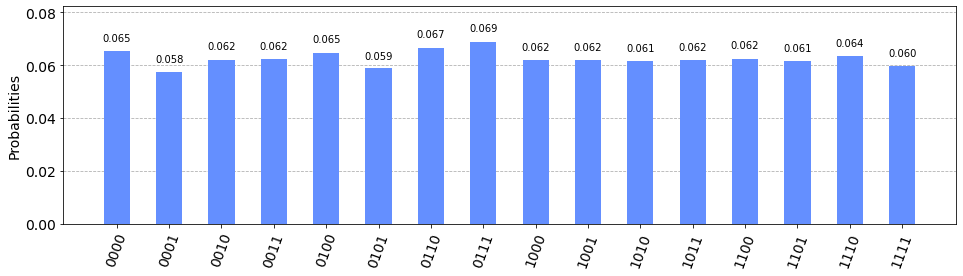

In [16]:
simulator = Aer.get_backend('qasm_simulator')
circuit = transpile(circuit, backend=simulator)
sim_job = simulator.run(circuit, shots=10000)
sim_result = sim_job.result()
plot_histogram(sim_result.get_counts(circuit), figsize=(16, 4))

実機ではどんな結果が得られるでしょうか。

In [17]:
backend_list = provider.backends(filters=operational_backend(min_qubits=circuit.num_qubits))
backend = least_busy(backend_list)

print('Jobs will run on', backend.name())

NameError: name 'provider' is not defined

In [18]:
circuit_tr = transpile(circuit, backend=backend)
job = backend.run(circuit_tr, shots=8192)

job_monitor(job, interval=2)

NameError: name 'backend' is not defined

In [19]:
result = job.result()
plot_histogram(result.get_counts(0), figsize=(16, 4))

NameError: name 'job' is not defined

シミュレータでの結果とずれていたら、トランスパイルした回路`circuit_tr`を見て原因を考えてみてください。作ったのは一見単純な回路ですが、実際に実行されるものはどうなっているでしょうか。

In [20]:
circuit_tr.draw('mpl')

NameError: name 'circuit_tr' is not defined

**提出するもの**

- 完成した回路のコードと実行結果（実機とシミュレータ）のヒストグラム
- ヒストグラムから何が読み取れるかの考察
- `haystack`レジスタが一般の$n$ビットであるとき、この方法で`needle`を探すことの問題点（実行時間の観点から）に関する考察

## 参考文献

```{bibliography}
:filter: docname in docnames
```